# Pokemon Classification

In [180]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import torch
import matplotlib.pyplot as plt
import pickle
from torchvision.transforms import Compose    

In [181]:
from torch.utils.data import Dataset

class TransformSubset(Dataset):
    """
    Wrapper for applying transformations to a Subset.
    """
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)


In [197]:
class PokemonDataModule(Dataset):
    def __init__(self, data_dir):
        self.dataset = ImageFolder(root=data_dir)
        self.class_names = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def plot_examples(self, dataloader, n_rows=1, n_cols=4, stats=None):
        """
        Plot examples from a DataLoader.
    
        Args:
            dataloader (DataLoader): DataLoader object to fetch images and labels from.
            n_rows (int): Number of rows in the plot grid.
            n_cols (int): Number of columns in the plot grid.
            denormalize (callable, optional): Function to reverse normalization for visualization. 
                                              Should accept a tensor and return a denormalized tensor.
        """
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
        axes = axes.flatten()  # Flatten to iterate easily
    
        # Iterate over the dataloader to get a batch of data
        for data, labels in dataloader:
            # Take the first n_rows * n_cols samples from the batch
            for i, ax in enumerate(axes[:n_rows * n_cols]):
                if i >= len(data):  # If fewer samples than the grid size, stop
                    break
                
                img, label = data[i], labels[i]
    
                # Apply denormalization if provided
                if stats:
                    img = self._denormalize(img, stats)
                
                # Convert CHW to HWC for plotting
                img = img.permute(1, 2, 0).cpu().numpy()
    
                ax.imshow(img)
                ax.set_title(self.class_names[label.item()])
                ax.axis('off')
            break  # Only process the first batch
    
        plt.tight_layout()
        plt.show()

    def _denormalize(self, img, stats):
        """
        Denormalize an image tensor.
    
        Args:
            img (Tensor): Image tensor with shape (C, H, W).
            stats (dict): Dictionary containing 'means' and 'stds' for each channel.
                          Example: {'means': [0.485, 0.456, 0.406], 'stds': [0.229, 0.224, 0.225]}.
    
        Returns:
            Tensor: Denormalized image tensor.
        """
        return img * stats['std'].view(-1, 1, 1) + stats['mean'].view(-1, 1, 1)

    def _get_stats(self, dataset):
        """
        Calculate the mean and standard deviation of the dataset for standardization.
        """
        dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)
        total_sum, total_squared_sum, total_count = 0, 0, 0
        with torch.cuda.device(0):
            for data, _ in dataloader:
                data.cuda()
                total_sum += data.sum(dim=(0, 2, 3))
                total_squared_sum += (data ** 2).sum(dim=(0, 2, 3))
                total_count += data.size(0) * data.size(2) * data.size(3)
    
            means = total_sum / total_count
            stds = torch.sqrt((total_squared_sum / total_count) - (means ** 2))
        return means, stds

    def prepare_data(self,
                     indices_file='indices.pkl',
                     get_stats=False
                    ):
        """
        Prepare train and test dataloaders with optional transformations.
        
        Args:
            indices_file (str): Path to save or load train/test indices.
            transform (callable): Primary transformation to apply to the data.
            additional_transforms (callable): Additional transformations to compose.
        
        Returns:
            tuple: trainloader, testloader
        """
        try:
            with open(indices_file, 'rb') as f:
                self.train_indices, self.test_indices = pickle.load(f)
        except (EOFError, FileNotFoundError):
            # Generate new indices if file is empty or doesn't exist
            self.train_indices, self.test_indices = train_test_split(
                range(len(self.dataset)),
                test_size=0.2,
                stratify=self.dataset.targets,
                random_state=42
            )
            
            # Ensure directory exists before saving
            os.makedirs(os.path.dirname(indices_file) or '.', exist_ok=True)
            
            with open(indices_file, 'wb') as f:
                pickle.dump([self.train_indices, self.test_indices], f)

        # Prepare train and test subsets
        self.train_dataset = Subset(self.dataset, self.train_indices)
        self.test_dataset = Subset(self.dataset, self.test_indices)
        
        return self._get_stats(self.train_dataset) if get_stats else None

    def get_dataloaders(self,
                    train_transform=None,
                    test_transform=None,
                    train_batch_size=None,
                    test_batch_size=None):
            """
            Prepare train and test dataloaders with optional transformations.
            
            Args:
                train_transform (callable): Transformation to apply to training data.
                train_batch_size (int): Batch size for the training dataloader.
                validation_batch_size (int): Batch size for the validation dataloader.
            
            Returns:
                tuple: trainloader, testloader
            """
            assert self.train_dataset is not None, "You need to call `prepare_data` before using `get_dataloaders`."
            
            # Default batch sizes if not provided
            test_batch_size = train_batch_size if test_batch_size is None else test_batch_size
            
            # Wrap subsets in a transformed dataset if transformations are provided
            train_dataset = TransformSubset(self.train_dataset, train_transform) if train_transform else self.train_dataset
            
            test_dataset = TransformSubset(self.test_dataset, test_transform) if test_transform else self.test_dataset
            
            trainloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
            testloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
            
            return trainloader, testloader


In [198]:
DATA_DIR = "/kaggle/input/pokemonclassification/PokemonData"
INDICIES_FILE = "/kaggle/input/pokindicies/indices.pkl"

pokemon_dataset = PokemonDataModule(DATA_DIR)

In [199]:
# Get class names
print(f"Number of classes: {len(pokemon_dataset.class_names)}")

Number of classes: 150


In [200]:
# You can only the use precomputed means and vars if using the same indices file ('indices.pkl')
chanel_means = torch.tensor([0.6062, 0.5889, 0.5550])
chanel_vars = torch.tensor([0.3284, 0.3115, 0.3266])
stats = {"mean":chanel_means, "std":chanel_vars}

pokemon_dataset.prepare_data(indices_file=INDICIES_FILE, get_stats=False)

In [201]:
print(f"Train dataset size: {len(pokemon_dataset.train_dataset)}")
print(f"Test dataset size: {len(pokemon_dataset.test_dataset)}")

Train dataset size: 5456
Test dataset size: 1364


In [207]:
IMG_SHAPE = ((256,265))

In [208]:
# Transformations of data for testing  
test_transform=transforms.Compose([
        transforms.Resize(IMG_SHAPE),
        transforms.ToTensor(),       # Convert PIL images to tensors
        transforms.Normalize(**stats), # Normalize images using mean and std

])

In [209]:
# Data augmentations for training 
train_transform=transforms.Compose([
        transforms.Resize(IMG_SHAPE),
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.RandomAdjustSharpness(2),  # Adjust sharpness randomly
        transforms.ToTensor(),       # Convert PIL images to tensors
        transforms.Normalize(**stats), # Normalize images using mean and std

])

In [210]:
# get dataloaders
trainloader, testloader= pokemon_dataset.get_dataloaders(train_transform=train_transform,
                                                         test_transform=test_transform,
                                                         train_batch_size=64,
                                                         test_batch_size=512
                                                        )

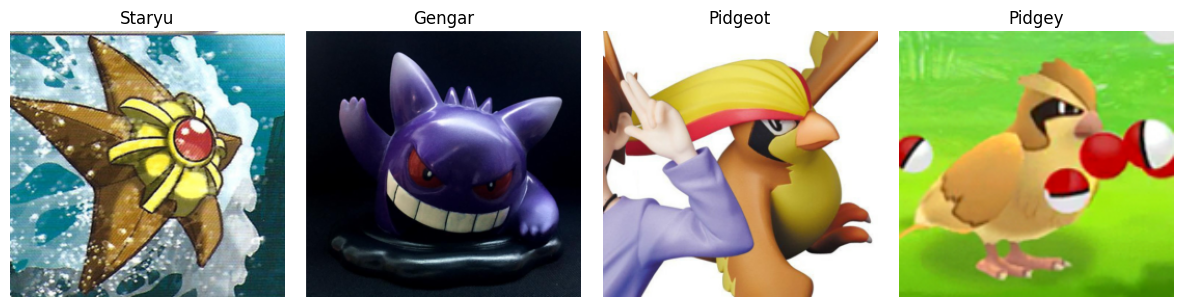

In [211]:
pokemon_dataset.plot_examples(testloader, stats=stats)

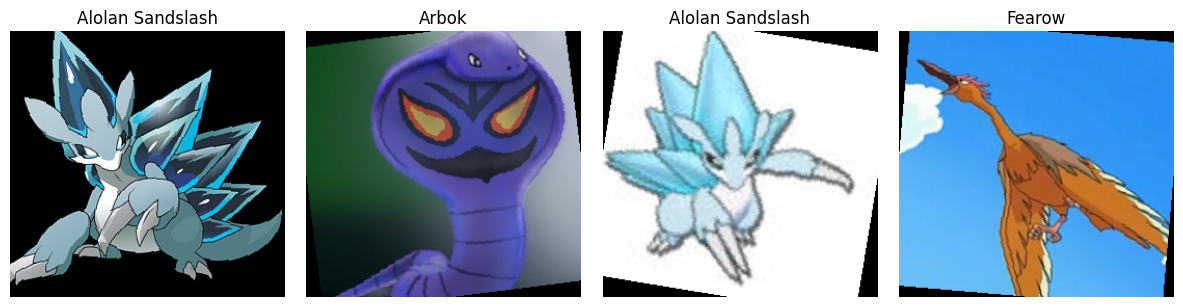

In [212]:
pokemon_dataset.plot_examples(trainloader, stats=stats)